In [58]:
import re
import random
import pandas as pd
import hashlib

In [59]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [60]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure Compute Gallery,151.454729,3.786368,13.063292,40
C# Basics,413.589605,13.341600,25.640417,31
Open Source/GitHub,604.638549,100.773092,175.821908,6
Azure Private DNS,623.857149,32.834587,55.189868,19
RAG Project,763.208614,47.700538,113.104496,16
Azure AD Authentication,901.356630,69.335125,176.683738,13
Azure Functions + Visual Studio,952.599428,73.276879,282.003987,13
Email Auth and Security,1007.518355,83.959863,182.148488,12
Audit Report Tracker (Sharepoint List),1015.262834,92.296621,267.289718,11
WSL + Kali Linux,1285.022630,91.787331,380.045252,14


# Histogram

sum of ages: ~46836.72


<Axes: >

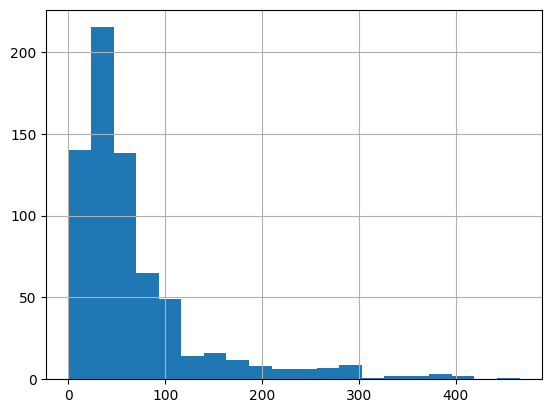

In [61]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [62]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [63]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [64]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [65]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [66]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [67]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [68]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [69]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [70]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [71]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 696
Total card age: 46836.72


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
23,Azure Developer Associate,What Azure feature should you use to securely ...,f919b56337ef29a1daaa6ec0b63377fe,-465.762482,75.78456,-465.762482,5153.35007,0.8507,0,0
24,Azure Developer Associate,Which diagnostic tool lets you trace and troub...,e394ed4a2e0097b5d916f27fa5eba3ea,-292.121119,75.78456,-465.762482,5153.35007,0.8507,3,0
25,Azure Developer Associate,Q: Which Azure Redis tier supports persistence...,c58372069d8ce641766af73c06f8e6a6,-158.689452,75.78456,-465.762482,5153.35007,0.8507,6,0
26,Azure Developer Associate,How do you send Azure Monitor platform metrics...,ebd7a4936138b81155060e59e1871824,-123.580551,75.78456,-465.762482,5153.35007,0.8507,9,0
269,Azure Developer Associate,What’s the default ingestion and retention for...,41e86cdb13719f9c696b1c701e12239c,-110.916536,75.78456,-465.762482,5153.35007,0.8507,12,0
28,Azure Developer Associate,Front: Name the five Cosmos DB consistency lev...,efa152853c9d25df64b84d537929c5d1,-96.468835,75.78456,-465.762482,5153.35007,0.8507,15,0
29,Azure Developer Associate,How does the Always restart policy differ from...,0858a8d05dbc45117b3d0f1dd538772b,-74.452259,75.78456,-465.762482,5153.35007,0.8507,18,0
504,Azure Developer Associate,"How do you expose only necessary operations, s...",5de0802db75f5a5af26e567cddae4eef,-59.980171,75.78456,-465.762482,5153.35007,0.8507,21,0
505,Azure Developer Associate,How do you correlate errors from Application I...,d2b1cb71a345cc2e58099a4572434c25,-55.119610,75.78456,-465.762482,5153.35007,0.8507,24,0
31,Azure Developer Associate,How do you ensure Event Grid events that fail ...,240bd178793ec4300f6b066c8ef85062,-52.599920,75.78456,-465.762482,5153.35007,0.8507,27,0


## Card Count

In [72]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [73]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [74]:
existing_cards.sort_values('age').head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
23,Azure Developer Associate,What Azure feature should you use to securely ...,f919b56337ef29a1daaa6ec0b63377fe,-465.762482,75.784560,-465.762482,5153.350070,0.850700,0,0
265,Azure Developer Associate,Q: What is Azure Cache for Redis?\nA: A fully ...,5bc9505ae30a8c09e1c0c220c2b6d7b3,-409.607146,75.784560,-465.762482,5153.350070,0.850700,1,1
46,Powershell Modules,CurrentUser Scope\n\nDefinition: An installati...,f3d0d03320782899e1352f748fc1cda5,-398.164210,103.671553,-398.164210,4561.548320,0.682473,0,0
173,WSL + Kali Linux,WSLg (Windows Subsystem for Linux GUI)\nA feat...,69051af876862485bdb54d8c645a8a40,-380.045252,91.787331,-380.045252,1285.022630,0.061108,0,0
288,Powershell Modules,Auto-Import\n\nDefinition: A feature in PowerS...,6b1412630951dc5fee8ffa437ee0e0f2,-377.312842,103.671553,-398.164210,4561.548320,0.682473,1,1
79,PnP PowerShell,New-PnPList (PnP.PowerShell)\nCreates a new Sh...,9d9dc3700f5078d8eaff9507709eaacb,-372.790749,68.305042,-372.790749,4303.217638,0.884976,0,0
61,JavaScript Concepts,Arrow Functions: Arrow functions provide a con...,2e3769781211a560564f81d13f2051b9,-355.799107,87.057782,-355.799107,4527.004678,0.564508,0,0
520,Powershell Modules,Get-Module\n\nDefinition: A cmdlet that retrie...,0d76065f3213ee411ee6f7e377583cc9,-354.606393,103.671553,-398.164210,4561.548320,0.682473,2,2
144,Terraform,Terraform allows you to manage the resources i...,05fa95392fe5544d07eec6db3a93ccb6,-346.593827,71.773570,-346.593827,1722.565687,0.537248,0,0
129,FSLogix,"During a first-time sign-in, FSLogix creates t...",f2d84db5972e92abd44bdb7e0c5686a7,-339.013181,102.833531,-339.013181,2262.337675,0.472278,0,0


In [75]:
existing_cards.head(10).sum()

head                   Azure Developer AssociateAzure Developer Assoc...
body                   What Azure feature should you use to securely ...
hash                   f919b56337ef29a1daaa6ec0b63377fee394ed4a2e0097...
age                                                         -1489.690935
subject_mean_age                                              757.845599
subject_highest_age                                         -4657.624817
subject_age_sum                                             51533.500702
head_random_roll                                                8.507004
count                                                                135
n_fold                                                                 0
dtype: object

In [76]:
existing_cards['age'].mean()

-67.29413382744364